In [ ]:
pip install --upgrade torch torchvision torchaudio

In [ ]:
pip install -U sentence_transformers

In [ ]:
from google.colab import drive
import json
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict
import numpy as np

### Baseline Model: Cosine Similarity

# compute cosine simlarity between each element in the embeddings
# softmax to get probabilities

# Get the train test split
target_dict = defaultdict(list)
cols = ['Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'No Finding', 'deid_patient_id', 'study_num']


In [ ]:
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/CSCI544/'

Mounted at /content/drive


In [ ]:
#folder_path = ''

In [ ]:
def load_and_preprocess():
  # Load the CSV file into a DataFrame
  jsonl_df = pd.read_json(folder_path + 'findings_fixed.json', lines=True)
  csv_df = pd.read_csv(folder_path + 'df_chexpert_plus_240401.csv')
  print(jsonl_df.columns)


  merged_df = pd.merge(jsonl_df, csv_df, on='path_to_image')

  # Filter DataFrame to include only rows where 'section_findings' is not null
  df = merged_df[merged_df['section_findings'].notna()]
  df.replace(-1, 1, inplace=True)
  df.replace(np.nan, 0, inplace=True)

  # Add study number column
  def extract_study_number(path):
    match = re.search(r"study(\d+)", path)
    if match:
        return match.group(1)
    return None

  df['study_num'] = df['path_to_image'].apply(extract_study_number)

  # Remove duplicate points with same patient id and study number
  df = df.drop_duplicates(subset=['deid_patient_id'])

  return df


In [ ]:
num_samples = 20000
filtered_df = load_and_preprocess()[0:num_samples]

display(filtered_df[cols])
reports = filtered_df['report']

Index(['path_to_image', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'No Finding'],
      dtype='object')


<ipython-input-4-4d3efa5f030c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(-1, 1, inplace=True)
<ipython-input-4-4d3efa5f030c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(np.nan, 0, inplace=True)
<ipython-input-4-4d3efa5f030c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['study_num'] = df['path_to_image'].apply(extract_study_number)


,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,deid_patient_id,study_num
8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,patient04528,1
15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,patient11162,3
50,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,patient30791,2
53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,patient04986,2
78,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,patient05496,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190280,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,patient12328,3
190283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,patient30954,1
190286,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,patient63241,1
190300,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,patient62360,2


In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# 2. Calculate embeddings by calling model.encode()
reports = [str(report) for report in reports]
embeddings = torch.tensor(model.encode(reports))

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
similarities.fill_diagonal_(-float('inf'))
target_indices = torch.argmax(similarities, axis=1)
target_dict = {column: [] for column in cols}
for column in cols:
    target_dict[column] = filtered_df.iloc[target_indices][column].tolist()

predictions = pd.DataFrame.from_dict(target_dict)
display(predictions)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:


# compute cosine simlarity between each element in the embeddings
# softmax to get probabilities
# choose most probable labels
# for i, embedding in enumerate(embeddings):
#   target_idx = np.argmax(softmax([cosine_similarity(embedding, other) if i != j else -float('inf') for j, other in enumerate(embeddings)]))
#   [target_dict[column].append(target) for column, target in zip(cols, filtered_df.iloc[target_idx][cols])]
# Calculate the cosine similarity matrix
# Normalizing the embeddings to unit vectors
norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
cosine_similarity_matrix = np.dot(norm_embeddings, norm_embeddings.T)

np.fill_diagonal(cosine_similarity_matrix, -np.inf)
softmax_values = np.exp(cosine_similarity_matrix) / np.sum(np.exp(cosine_similarity_matrix), axis=1, keepdims=True)
target_indices = np.argmax(softmax_values, axis=1)
target_dict = {column: [] for column in cols}
for column in cols:
    target_dict[column] = filtered_df.iloc[target_indices][column].tolist()

predictions = pd.DataFrame.from_dict(target_dict)
display(predictions)
# compute F1

# Baseline Evaluation

In [ ]:
# Get two dataframes with same cols
cols_to_compare = ['Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'No Finding']
gt_labels = filtered_df[cols_to_compare].reset_index(drop=True)
pred_labels = predictions[cols_to_compare].reset_index(drop=True)

# Compare predictions with gt
comparison = gt_labels == pred_labels
equal_rows = comparison.all(axis=1)
num_correct = equal_rows.sum()
# print(equal_rows)
print("Accuracy = " + str(num_correct / num_samples))

# Print info abt correct predictions
matching_indices = equal_rows[equal_rows].index.tolist()
for i in matching_indices:
  print(filtered_df['deid_patient_id'].iloc[i] + ":study" + filtered_df['study_num'].iloc[i] +
        " --> " + predictions['deid_patient_id'].iloc[i] + ":study" + predictions['study_num'].iloc[i])

NameError: name 'predictions' is not defined

# Base LLM + Few Shot

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) hf_asaPdkoKNEuVEORRmCLHCPzQqpEnVoOsi
Invalid input. Must be one of ('y', 'yes', '1', 'n', 'no', '0', '')
Add token as git credential? (Y/n) 
Token is valid (permission: read).
The token `NLP_USC` has been saved to /root/.cache/huggingface/

In [ ]:

import transformers
import torch
from google.colab import userdata
userdata.get('HF_TOKEN')
from huggingface_hub import login
from transformers import AutoModelForCausalLM
!pip install bitsandbytes>=0.39.0
!pip install -U bitsandbytes

from transformers import BitsAndBytesConfig

In [ ]:
zero_shot_prompt = f"""You are a medical assistant, specalizing in diagnosing diseases by looking at reports and impressions. \n
Your task is to analyze the findings of a patient's medical report and classify the presence (1) or absence (0) of each of the following 14 diseases.\n

Diseases: \n
1.Enlarged Cardiomediastinum
2.Cardiomegaly
3.Lung Opacity
4.Lung Lesion
5.Edema
6.Consolidation
7.Pneumonia
8.Atelectasis
9.Pneumothorax
10.Pleural Effusion
11.Pleural Other
12.Fracture
13.Support Devices
14.No Finding \n

Instructions: Read the 'Findings' and the 'Impressions' sections of the report. Then for each disease, decide whether it is present or absent.\n
Use YAML as the output format.\n

examples
  "```yaml\n
  "entities:\n
  " - groups:\n
  "   ENLARGED CARDIOMEDIASTINUM: 0\n"
  "   CARDIOMEGALY: 0\n"
  "   LUNG OPACITY: 0\n"
  "   ...\n"
  "   NO FINDING: 1\n"
  "```\n"
"""

In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

def predict_labels(prompt, reports, outputs, input):
   # Paste your access token here
  messages = [
      {"role": "system", "content": prompt},
  ]

  for report, output in zip(reports, outputs):
    messages.append({"role": "user", "content": report})
    messages.append({"role": "user", "content": output})

  messages.append({"role": "user", "content": f"Now predict the 14 labels for the following: {input}"})

  terminators = [
      pipeline.tokenizer.eos_token_id,
      pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
  ]

  outputs = pipeline(
      messages,
      max_new_tokens=256,
      eos_token_id=terminators,
      pad_token_id=pipeline.tokenizer.eos_token_id,
      do_sample=True,
      temperature=0.6,
      top_p=0.9,
  )

  return outputs[0]["generated_text"][-1]



zero_shot = predict_labels(zero_shot_prompt, [], [], reports.iloc[2])
print(zero_shot)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

In [ ]:
print(reports.iloc[0])

NARRATIVE:
RADIOGRAPHIC EXAMINATION OF THE CHEST: 6/3/17
 
CLINICAL HISTORY: 61 years of age, Female, R o infiltarate..AML 
(acute myeloblastic leukemia)
 
COMPARISON: 06/2017
 
PROCEDURE COMMENTS: Two views of the chest. 
 
FINDINGS:
 
Unchanged position of the left upper extremity PICC line. Again seen 
are surgical clips projecting over the right hemithorax. The 
cardiomediastinal silhouette is stable in appearance. Increased 
stranding opacities are noted in the left retrocardiac region. Subtle 
stranding opacities in the right upper lung zone are unchanged.. 
There are no pleural or significant bony abnormalities. Absence of 
the right breast shadow compatible with prior mastectomy.
 
IMPRESSION:
 
1.  Interval development of a band of increased linear stranding 
opacities in the left retrocardiac region. Although this may 
represent subsegmental atelectasis, an early or developing 
consolidation could have similar appearance. Recommend clinical 
correlation.
 
 
 
ACCESSION NUMBE

In [ ]:
{'role': 'assistant', 'content': 'Here are the predictions for the 14 labels in YAML format:\n\n```\nentities:\n  - groups:\n    ENLARGED CARDIOMEDIASTINUM: 0\n    CARDIOMEGALY: 0\n    LUNG OPACITY: 1\n    LUNG LESION: 1\n    EDema: 0\n    CONSOLIDATION: 1\n    PNEUMONIA: 0\n    ATELECTASIS: 1\n    PNEUMOTHORAX: 0\n    PLEURAL EFFUSION: 0\n    PLEURAL OTHER: 0\n    FRACTURE: 0\n    SUPPORT DEVICES: 0\n    NO FINDING: 0\n```\n\nNote that the presence of a band of increased linear stranding opacities in the left retrocardiac region suggests the possibility of subsegmental atelectasis or early or developing consolidation, which is why I classified the presence of Lung Opacity, Lung Lesion, and Consolidation as 1. The absence of pleural or significant bony abnormalities and the stable appearance of the cardiomediastinal silhouette suggest that the other diseases are absent.'}

In [ ]:
disease_columns = [
    "report", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
    "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
]

def few_shot_labeler():

  few_shot_examples = filtered_df[disease_columns].sample(1)  # Randomly sample examples

  # Format the examples for the few-shot prompt
  few_shot_reports = few_shot_examples["report"].tolist()
  few_shot_labels = []
  for _, row in few_shot_examples.iterrows():
      # Collect labels from the 14 columns
      formatted_labels = "\n".join(
          [f"- {col.upper().replace(' ', '_')}: {row[col]}" for col in disease_columns if col != "report"]
      )
      few_shot_labels.append(formatted_labels)
  return few_shot_reports, few_shot_labels


In [ ]:
few_shot_prompt = f"""You are a medical assistant, specalizing in diagnosing diseases by looking at reports and impressions. \n
Your task is to analyze the findings of a patient's medical report and classify the presence (1) or absence (0) of each of the following 14 diseases.\n

Diseases: \n
1.Enlarged Cardiomediastinum
2.Cardiomegaly
3.Lung Opacity
4.Lung Lesion
5.Edema
6.Consolidation
7.Pneumonia
8.Atelectasis
9.Pneumothorax
10.Pleural Effusion
11.Pleural Other
12.Fracture
13.Support Devices
14.No Finding \n

Instructions: Read the 'Findings' and the 'Impressions' sections of the report. Then for each disease, decide whether it is present or absent.\n

Example of disease labels classified accurately are shown below.\n

"""

In [ ]:
!pip install groq


In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

def predict_labels(prompt, reports, outputs, input):
   # Paste your access token here
  messages = [
      {"role": "system", "content": prompt},
  ]

  for report, output in zip(reports, outputs):
    messages.append({"role": "user", "content": report})
    messages.append({"role": "user", "content": output})

  messages.append({"role": "user", "content": f"Now predict the 14 labels for the following: {input}"})

  terminators = [
      pipeline.tokenizer.eos_token_id,
      pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
  ]

  outputs = pipeline(
      messages,
      max_new_tokens=256,
      eos_token_id=terminators,
      pad_token_id=pipeline.tokenizer.eos_token_id,
      do_sample=True,
      temperature=0.6,
      top_p=0.9,
  )

  return outputs[0]["generated_text"][-1]

zero_shot = predict_labels(zero_shot_prompt, [], [], reports.iloc[2])
print(zero_shot)

In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
from groq import Groq
client = Groq(
    api_key= userdata.get('GROQ_API_KEY'),
)
def predict_labels_groq(prompt, reports, outputs, input_text):
    # Construct the messages for the Groq model
    messages = [
        {"role": "system", "content": prompt},
    ]

    for report, output in zip(reports, outputs):
        messages.append({"role": "user", "content": report})
        messages.append({"role": "user", "content": output})

    messages.append({"role": "user", "content": f"Now predict the 14 labels for the following: \n {input_text}"})

    # Call the Groq Chat Completion API
    response = client.chat.completions.create(
        model="llama3-8b-8192",  # Specify the model to use
        messages=messages,
        max_tokens=256,
        temperature=0.6,
        top_p=0.9,
    )

    # Extract and return the generated text
    return response.choices[0].message.content

zero_shot = []

In [ ]:
# Few shot sampling
from tqdm import tqdm

with open(f"one_shot.txt", "w") as file:
  file.write("")

for i in tqdm(range(200, 300)):
  sample_reports, sample_labels = few_shot_labeler()
  instruction_string = "Now read the 'Findings' and the 'Impressions' sections of the following report. Then for each disease, decide whether it is present or absent. Output as the format shown in the example."
  few_shot_string = few_shot_prompt + sample_reports[0] + "\n\nClassification:\n"  + sample_labels[0] + "\n\n" + instruction_string

  few_shot = predict_labels_groq(few_shot_string, [], [], reports.iloc[i])
  with open(f"one_shot.txt", "a") as file:
    file.write(few_shot + "\n")
    file.write("#######" + "\n")
  # print(f"Predictions for row {i + 1}:\n{zero_shot}\n")


100%|██████████| 100/100 [03:13<00:00,  1.93s/it]


In [ ]:
file_path = folder_path+'zero_shot_100_examples.txt'

with open(file_path, 'r') as file:
    content = file.read()

blocks = re.findall(r'groups:\s*([\s\S]*?)(?=\n\n|$)', content)
predicted_labels = []
for block in blocks:
    labels = dict(re.findall(r'(\w[\w\s]+):\s*(\d)', block))
    predicted_labels.append(labels)

predicted_df = pd.DataFrame(predicted_labels)
expected_columns = [
    "ENLARGED CARDIOMEDIASTINUM", "CARDIOMEGALY", "LUNG OPACITY", "LUNG LESION",
    "EDEMA", "CONSOLIDATION", "PNEUMONIA", "ATELECTASIS", "PNEUMOTHORAX",
    "PLEURAL EFFUSION", "PLEURAL OTHER", "FRACTURE", "SUPPORT DEVICES", "NO FINDING"
]
predicted_df = predicted_df.reindex(columns=expected_columns)

predicted_df = predicted_df.fillna(0).astype(int)

print("Predicted Labels DataFrame:")
print(predicted_df.head())

[{'ENLARGED CARDIOMEDIASTINUM': '0', 'CARDIOMEGALY': '0', 'LUNG OPACITY': '1', 'LUNG LESION': '1', 'EDema': '0', 'CONSOLIDATION': '1', 'PNEUMONIA': '0', 'ATELECTASIS': '0', 'PNEUMOTHORAX': '0', 'PLEURAL EFFUSION': '0', 'PLEURAL OTHER': '0', 'FRACTURE': '0', 'SUPPORT DEVICES': '0', 'NO FINDING': '0'}, {'ENLARGED CARDIOMEDIASTINUM': '0', 'CARDIOMEGALY': '0', 'LUNG OPACITY': '0', 'LUNG LESION': '0', 'EDema': '0', 'CONSOLIDATION': '0', 'PNEUMONIA': '0', 'ATELECTASIS': '1', 'PNEUMOTHORAX': '0', 'PLEURAL EFFUSION': '1', 'PLEURAL OTHER': '0', 'FRACTURE': '0', 'SUPPORT DEVICES': '1', 'NO FINDING': '0'}, {'ENLARGED CARDIOMEDIASTINUM': '0', 'CARDIOMEGALY': '0', 'LUNG OPACITY': '1', 'LUNG LESION': '1', 'EDema': '1', 'CONSOLIDATION': '1', 'PNEUMONIA': '1', 'ATELECTASIS': '0', 'PNEUMOTHORAX': '0', 'PLEURAL EFFUSION': '1', 'PLEURAL OTHER': '0', 'FRACTURE': '0', 'SUPPORT DEVICES': '0', 'NO FINDING': '0'}, {'ENLARGED CARDIOMEDIASTINUM': '0', 'CARDIOMEGALY': '0', 'LUNG OPACITY': '0', 'LUNG LESION': '1'

# Instruction-Tuned + SFT

In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
#!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.47.0.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:

def data_labeler(example):
  # Format the examples for the few-shot prompt
  labels = []
  reports = example["report"]
  formatted_labels = "\n".join(
      [f"- {col.upper().replace(' ', '_')}: {example[col]}" for col in disease_columns if col != "report"]
  )
  labels.append(formatted_labels)
  return reports, labels

inputs, outputs = zip(*[(data_labeler(row)) for _, row in filtered_df[disease_columns].iterrows()])
#[print(f"input: {input}, output: {output}") for input, output in zip(inputs, outputs)]
dataset = pd.DataFrame({"instruction": [zero_shot_prompt] * len(inputs), "input": inputs, "output": outputs})

dataset.head()
from datasets import Dataset
dataset = Dataset.from_pandas(dataset)

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

#dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
11.85 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 20,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,6.995100
2,6.977100
3,6.755300
4,6.524900
5,6.077000
6,5.836100
7,5.425900
8,4.933600
9,4.480700
10,3.981600


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1216.2975 seconds used for training.
20.27 minutes used for training.
Peak reserved memory = 13.971 GB.
Peak reserved memory for training = 2.121 GB.
Peak reserved memory % of max memory = 94.731 %.
Peak reserved memory for training % of max memory = 14.382 %.


In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

FastLanguageModel.for_inference(model) # Enable native 2x faster inference
output_file = "instruct_few_shot_0_1000.txt"

### Switch between zero shot and few shot

# Zero Shot
zero_shot_string = zero_shot_prompt + f"\nNow predict the 14 labels for the following:"

with open(output_file, "a") as file:
    for i in range(1000):
        # Few Shot, comment if doing zero shot
        sample_reports, sample_labels = few_shot_labeler()
        instruction_string = "Now read the 'Findings' and the 'Impressions' sections of the following report. Then for each of the 14 diseases, decide whether it is present or absent."
        few_shot_string = few_shot_prompt + sample_reports[0] + "\n\nClassification:\n"  + sample_labels[0] + "\n\n" + instruction_string

        input_text = reports.iloc[i]
        inputs = tokenizer(
        [
            alpaca_prompt.format(
                few_shot_string, # instruction
                input_text, # input
                "", # output - leave this blank for generation!
            )
        ], return_tensors = "pt").to("cuda")

        outputs = model.generate(**inputs, max_new_tokens = 216, use_cache = True)
        decoded = tokenizer.batch_decode(outputs)
        response = decoded[0].split("### Response:", 1)[1]
        print(response)
        file.write(response + "\n")

# Output Processing

In [ ]:
files_list = ['zero_shot_0_100.txt','zero_shot_100_200.txt', 'zero_shot_200_300.txt','zero_shot_300_400.txt', 'zero_shot_400_500.txt', 'zero_shot_500_750.txt', 'zero_shot_750_1000.txt']
#files_list = ['one_shot_0_100.txt']

total_accuracy = 0
total_per_label_accuracy = 0
total_true_positives = 0
total_false_positives = 0
total_false_negatives = 0
for i in range(len(files_list)):
  file_path = folder_path+files_list[i]

  with open(file_path, 'r') as file:
      content = file.read()

  blocks = re.findall(r'groups:\s*([\s\S]*?)(?=\n\n|$)', content)
  predicted_labels = []
  for block in blocks:
      labels = dict(re.findall(r'(\w[\w\s]+):\s*([\d.]+)', block))
      predicted_labels.append(labels)
  print(predicted_labels)
  predicted_df = pd.DataFrame(predicted_labels)
  if ('EDEMA' in predicted_df.columns and 'EDema' in predicted_df.columns ):
    predicted_df['EDEMA'] = predicted_df['EDema'].combine_first(predicted_df['EDEMA'])
  if ('PNEUMONIA' in predicted_df.columns and '5\n    PNEUMONIA' in predicted_df.columns ):
    predicted_df['PNEUMONIA'] = predicted_df['PNEUMONIA'].combine_first(predicted_df['5\n    PNEUMONIA'])
  if ('ATELECTASIS' in predicted_df.columns and '5\n    ATELECTASIS' in predicted_df.columns ):
    predicted_df['ATELECTASIS'] = predicted_df['ATELECTASIS'].combine_first(predicted_df['5\n    ATELECTASIS'])

  #predicted_df.dropna(axis=1, inplace=True)

  if i==0:
    print(predicted_df.columns)
  expected_columns = [
      "ENLARGED CARDIOMEDIASTINUM", "CARDIOMEGALY", "LUNG OPACITY", "LUNG LESION",
      "EDEMA", "CONSOLIDATION", "PNEUMONIA", "ATELECTASIS", "PNEUMOTHORAX",
      "PLEURAL EFFUSION", "PLEURAL OTHER", "FRACTURE", "SUPPORT DEVICES", "NO FINDING"
  ]
  predicted_df = predicted_df.reindex(columns=expected_columns)

  predicted_df = predicted_df.fillna(0).astype(float)

  # print("Predicted Labels DataFrame:")
  # print(predicted_df.head())


  disease_labels = [
      "ENLARGED CARDIOMEDIASTINUM", "CARDIOMEGALY", "LUNG OPACITY", "LUNG LESION",
      "EDEMA", "CONSOLIDATION", "PNEUMONIA", "ATELECTASIS", "PNEUMOTHORAX",
      "PLEURAL EFFUSION", "PLEURAL OTHER", "FRACTURE", "SUPPORT DEVICES", "NO FINDING"
  ]
  if i==3:
    filtered_reports_df = filtered_df.iloc[298:400]
  elif i==4:
    filtered_reports_df = filtered_df.iloc[400:500]
  elif i==5:
    filtered_reports_df = filtered_df.iloc[500:749]
  elif i==6:
    filtered_reports_df = filtered_df.iloc[750:1000]
  else:
    filtered_reports_df = filtered_df.iloc[i*100:(i*100)+100]
  filtered_reports_df.columns = filtered_df.columns.str.upper().str.strip()

  filtered_reports_df = filtered_reports_df[disease_labels]
  predicted_df = predicted_df[filtered_reports_df.columns]
  #print(filtered_reports_df)

  #print(predicted_df)
  filtered_reports_df = filtered_reports_df.reset_index(drop=True)

  # print("PREDICTIONS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  # print(predicted_df[:10])

  # print("GROUND TRUTH~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  # print(filtered_reports_df[:10])

  predicted_df = predicted_df[:10]
  filtered_reports_df = filtered_reports_df[:10]

  exact_matches = (predicted_df == filtered_reports_df).all(axis=1)
  accuracy = exact_matches.mean() * 100
  print("Accuracy", i, accuracy)
  total_accuracy += exact_matches.sum()


print(f"Exact Match Accuracy: {total_accuracy/10:.2f}%")

[]
RangeIndex(start=0, stop=0, step=1)
Empty DataFrame
Columns: [ENLARGED CARDIOMEDIASTINUM, CARDIOMEGALY, LUNG OPACITY, LUNG LESION, EDEMA, CONSOLIDATION, PNEUMONIA, ATELECTASIS, PNEUMOTHORAX, PLEURAL EFFUSION, PLEURAL OTHER, FRACTURE, SUPPORT DEVICES, NO FINDING]
Index: []
   ENLARGED CARDIOMEDIASTINUM  CARDIOMEGALY  LUNG OPACITY  LUNG LESION  EDEMA  \
0                         1.0           0.0           1.0          0.0    0.0   
1                         0.0           0.0           0.0          0.0    1.0   
2                         1.0           0.0           1.0          0.0    1.0   
3                         0.0           0.0           0.0          0.0    0.0   
4                         0.0           1.0           0.0          0.0    1.0   

   CONSOLIDATION  PNEUMONIA  ATELECTASIS  PNEUMOTHORAX  PLEURAL EFFUSION  \
0            0.0        0.0          0.0           0.0               0.0   
1            0.0        0.0          1.0           0.0               1.0   
2        

ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

In [ ]:
files_list = ['one_shot_0_100.txt', 'one_shot_100_200.txt', 'one_shot_200_300.txt', \
              'one_shot_300_400.txt', 'one_shot_400_500.txt', 'one_shot_500_600.txt', 'one_shot_600_700.txt', \
              'one_shot_700_800.txt', 'one_shot_800_900.txt', 'one_shot_900_1000.txt']
# files_list = ['one_shot_0_100.txt']

total_accuracy = 0
total_per_label_accuracy = 0
total_true_positives = 0
total_false_positives = 0
total_false_negatives = 0

for i in range(len(files_list)):
  file_path = folder_path+files_list[i]

  with open(file_path, 'r') as file:
    content = file.read()

  blocks = content.strip().split("#######")

  # Initialize an empty list to store parsed dictionaries
  parsed_data = []

  # Define regex to extract key-value pairs
  pattern = r"\s*([\w_]+):\s*([\d.]+)"

  # Loop through each block and parse it
  for block in blocks:
    # Extract key-value pairs from the block
    matches = re.findall(pattern, block)

    # Convert matches into a dictionary and append to parsed_data
    parsed_data.append({key: float(value) for key, value in matches})

  # Convert the list of dictionaries into a pandas DataFrame
  predicted_df = pd.DataFrame(parsed_data)

  expected_columns = [
      "ENLARGED CARDIOMEDIASTINUM", "CARDIOMEGALY", "LUNG OPACITY", "LUNG LESION",
      "EDEMA", "CONSOLIDATION", "PNEUMONIA", "ATELECTASIS", "PNEUMOTHORAX",
      "PLEURAL EFFUSION", "PLEURAL OTHER", "FRACTURE", "SUPPORT DEVICES", "NO FINDING"
  ]
  predicted_df.columns = expected_columns
  predicted_df.drop(predicted_df.tail(1).index,inplace=True) # drop last n rows
  disease_labels = [
      "ENLARGED CARDIOMEDIASTINUM", "CARDIOMEGALY", "LUNG OPACITY", "LUNG LESION",
      "EDEMA", "CONSOLIDATION", "PNEUMONIA", "ATELECTASIS", "PNEUMOTHORAX",
      "PLEURAL EFFUSION", "PLEURAL OTHER", "FRACTURE", "SUPPORT DEVICES", "NO FINDING"
  ]

  # Get correct ground truths df
  filtered_reports_df = filtered_df.iloc[i*100:(i*100)+100]
  filtered_reports_df.columns = filtered_df.columns.str.upper().str.strip()

  filtered_reports_df = filtered_reports_df[disease_labels]
  predicted_df = predicted_df[filtered_reports_df.columns]
  filtered_reports_df = filtered_reports_df.reset_index(drop=True)

  # print("PREDICTIONS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  # print(predicted_df[:10])

  # print("GROUND TRUTH~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  # print(filtered_reports_df[:10])

  # print(predicted_df.shape)
  # print(filtered_reports_df.shape)

  exact_matches = (predicted_df == filtered_reports_df).all(axis=1)
  accuracy = exact_matches.mean() * 100
  print("Accuracy", i, accuracy)
  total_accuracy += accuracy

  # Per label comparison for TP, FP, FN
  true_positives = ((predicted_df == 1) & (filtered_reports_df == 1)).sum().sum()
  false_positives = ((predicted_df == 1) & (filtered_reports_df == 0)).sum().sum()
  false_negatives = ((predicted_df == 0) & (filtered_reports_df == 1)).sum().sum()
  per_label_match = (predicted_df == filtered_reports_df).sum().sum()
  per_label_accuracy = (predicted_df == filtered_reports_df).mean().mean() * 100
  total_per_label_accuracy += per_label_accuracy

  total_true_positives += true_positives
  total_false_positives += false_positives
  total_false_negatives += false_negatives

precision = total_true_positives/(total_true_positives+total_false_positives)
recall = total_true_positives/(total_true_positives+total_false_negatives)
f1_score = precision*recall/(precision+recall)

print(f"Exact Match Accuracy: {total_accuracy/len(files_list):.2f}%")
print(f"Per Label Accuracy: {total_per_label_accuracy/len(files_list):.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1_score:.4f}")

Accuracy 0 21.0
Accuracy 1 18.0
Accuracy 2 20.0
Accuracy 3 13.0
Accuracy 4 25.0
Accuracy 5 30.0
Accuracy 6 31.0
Accuracy 7 23.0
Accuracy 8 14.000000000000002
Accuracy 9 26.0
Exact Match Accuracy: 22.10%
Per Label Accuracy: 88.35%
Precision: 0.7364
Recall: 0.8111
F1: 0.3860


In [ ]:
# files_list = ['modified_instruct_few_shot_0_1000.txt']
files_list = ['instruct_few_shot_0_1000.txt']
# files_list = ['instruct_few_shot_0_1000 (updated).txt']

total_accuracy = 0
total_per_label_accuracy = 0
total_true_positives = 0
total_false_positives = 0
total_false_negatives = 0

total_matches = 0

for file_name in files_list:
    file_path = folder_path + file_name

    with open(file_path, 'r') as file:
        content = file.read()

    blocks = content.strip().split('<|end_of_text|>')
    # blocks = [block.strip() for block in blocks if block.strip()]

    # print(len(blocks))
    # break

    parsed_data = []

    pattern = r"- ([\w_]+): ([\d.]+)"

    output_columns = [
      "ENLARGED_CARDIOMEDIASTINUM", "CARDIOMEGALY", "LUNG_OPACITY", "LUNG_LESION",
      "EDEMA", "CONSOLIDATION", "PNEUMONIA", "ATELECTASIS", "PNEUMOTHORAX",
      "PLEURAL_EFFUSION", "PLEURAL_OTHER", "FRACTURE", "SUPPORT_DEVICES", "NO_FINDING"
    ]

    count = 0

    for block in blocks:
        count += 1

        matches = re.findall(pattern, block)
        if matches:
            parsed_data.append({key: float(value) for key, value in matches})
        else:
            print(count*2)
            parsed_data.append({key: 0 for key in output_columns})

    predicted_df = pd.DataFrame(parsed_data)
    print(predicted_df.columns)

    expected_columns = [
      "ENLARGED CARDIOMEDIASTINUM", "CARDIOMEGALY", "LUNG OPACITY", "LUNG LESION",
      "EDEMA", "CONSOLIDATION", "PNEUMONIA", "ATELECTASIS", "PNEUMOTHORAX",
      "PLEURAL EFFUSION", "PLEURAL OTHER", "FRACTURE", "SUPPORT DEVICES", "NO FINDING"
    ]
    predicted_df.columns = expected_columns
    print(predicted_df.columns)


    # print("Expected Columns:", expected_columns)
    # print("Filtered Columns:", filtered_df.columns.tolist())


    predicted_df.dropna(inplace=True)

    disease_labels = [
      "ENLARGED CARDIOMEDIASTINUM", "CARDIOMEGALY", "LUNG OPACITY", "LUNG LESION",
      "EDEMA", "CONSOLIDATION", "PNEUMONIA", "ATELECTASIS", "PNEUMOTHORAX",
      "PLEURAL EFFUSION", "PLEURAL OTHER", "FRACTURE", "SUPPORT DEVICES", "NO FINDING"
    ]

    num_to_compare = 400
    # filtered_reports_df = filtered_df.iloc[:len(predicted_df)].copy()
    filtered_reports_df = filtered_df.iloc[0:num_to_compare]
    filtered_reports_df.columns = filtered_df.columns.str.upper().str.strip()
    filtered_reports_df = filtered_reports_df[disease_labels]
    predicted_df = predicted_df.iloc[0:num_to_compare]
    # print(filtered_reports_df.columns)

    # missing_columns = set(expected_columns) - set(filtered_reports_df.columns)
    # for column in missing_columns:
    #   filtered_reports_df[column] = 1

    filtered_reports_df = filtered_reports_df[expected_columns].reset_index(drop=True)

    predicted_df = predicted_df.reset_index(drop=True)
    filtered_reports_df = filtered_reports_df.reset_index(drop=True)


    # print("PREDICTIONS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    # print(predicted_df[:10])

    # print("GROUND TRUTH~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    # print(filtered_reports_df[:10])

    # print(predicted_df.shape)
    # print(filtered_reports_df.shape)


    exact_matches = (predicted_df == filtered_reports_df).all(axis=1)
    total_matches += exact_matches.sum()
    accuracy = exact_matches.mean() * 100
    print(f"Accuracy for {file_name}: {accuracy:.2f}%")
    total_accuracy += accuracy


    true_positives = ((predicted_df == 1) & (filtered_reports_df == 1)).sum().sum()
    false_positives = ((predicted_df == 1) & (filtered_reports_df == 0)).sum().sum()
    false_negatives = ((predicted_df == 0) & (filtered_reports_df == 1)).sum().sum()
    per_label_accuracy = (predicted_df == filtered_reports_df).mean().mean() * 100

    total_true_positives += true_positives
    total_false_positives += false_positives
    total_false_negatives += false_negatives
    total_per_label_accuracy += per_label_accuracy


precision = total_true_positives / (total_true_positives + total_false_positives)
recall = total_true_positives / (total_true_positives + total_false_negatives)
f1_score = 2 * precision * recall / (precision + recall)


print(f"Overall Exact Match Accuracy: {total_accuracy / len(files_list):.2f}%")
print(f"Overall Per Label Accuracy: {total_per_label_accuracy / len(files_list):.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

print(f"\nTotal matches: {total_matches}")


2002
Index(['ENLARGED_CARDIOMEDIASTINUM', 'CARDIOMEGALY', 'LUNG_OPACITY',
       'LUNG_LESION', 'EDEMA', 'CONSOLIDATION', 'PNEUMONIA', 'ATELECTASIS',
       'PNEUMOTHORAX', 'PLEURAL_EFFUSION', 'PLEURAL_OTHER', 'FRACTURE',
       'SUPPORT_DEVICES', 'NO_FINDING'],
      dtype='object')
Index(['ENLARGED CARDIOMEDIASTINUM', 'CARDIOMEGALY', 'LUNG OPACITY',
       'LUNG LESION', 'EDEMA', 'CONSOLIDATION', 'PNEUMONIA', 'ATELECTASIS',
       'PNEUMOTHORAX', 'PLEURAL EFFUSION', 'PLEURAL OTHER', 'FRACTURE',
       'SUPPORT DEVICES', 'NO FINDING'],
      dtype='object')
Accuracy for instruct_few_shot_0_1000.txt: 25.00%
Overall Exact Match Accuracy: 25.00%
Overall Per Label Accuracy: 89.61%
Precision: 0.7751
Recall: 0.7476
F1 Score: 0.7611

Total matches: 100


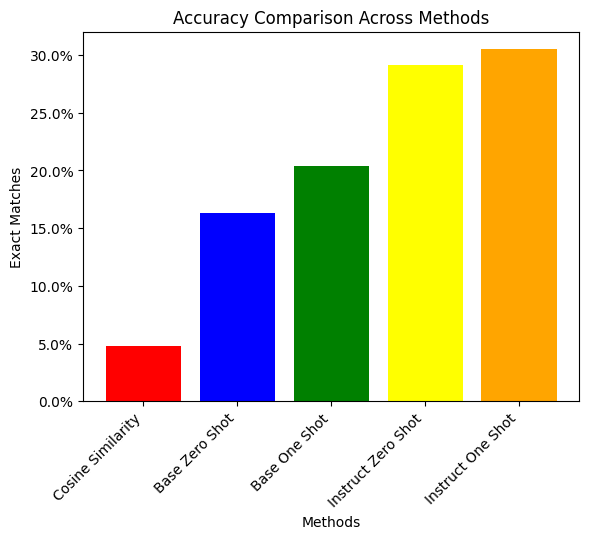

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


categories = ['Cosine Similarity', 'Base Zero Shot', 'Base One Shot','Instruct Zero Shot','Instruct One Shot']
values = [4.8, 16.3, 20.4,29.1,30.5]


colors = ['red', 'blue', 'green','yellow','orange']


plt.bar(categories, values, color=colors)

plt.xticks(rotation=45, ha='right')
plt.title('Accuracy Comparison Across Methods')
plt.xlabel('Methods')
plt.ylabel('Exact Matches')


def percent(x, pos):
    return f'{x}%'


plt.gca().yaxis.set_major_formatter(FuncFormatter(percent))

plt.show()
